In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

In [12]:
df_customer = pd.read_csv(r'/content/Case Study - Customer.csv', delimiter= ';')
df_product = pd.read_csv(r'/content/Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv(r'/content/Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv(r'/content/Case Study - Transaction.csv', delimiter=';')

In [13]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

Data Cleansing

In [14]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [15]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [ ]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [ ]:
#data cleansing df customer

df_customer ['Income'] = df_customer['Income'].replace('(,)','.',regex=True).astype('float')

In [16]:
#data cleansing df store

df_store['Latitude'] = df_store['Latitude'].replace('(,)','.',regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('(,)','.',regex=True).astype('float')

In [17]:
#data cleansing df transaction

df_transaction['Date'] = pd.to_datetime(df_transaction [ 'Date' ])

In [18]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845


In [19]:
df1 = pd.merge(df_transaction, df_customer, on='CustomerID', how='inner')
df2 = pd.merge(df1, df_store, on = 'StoreID', how = 'inner')
df_merged = pd.merge(df2, df_product, on = 'ProductID', how = 'inner')
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500


In [20]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  4976 non-null   object        
 11  Income          5020 non-null   object        
 12  StoreName       5020 non-null   object        
 13  GroupStore      5020 non-null   object        
 14  Type            5020 non-null   object        
 15  Lati

## Time Series

In [21]:
df_regresi_product= df_merged.groupby(['ProductID','Date']).agg({'Qty':'sum'}).reset_index()

In [22]:
df_regresi_product

,ProductID,Date,Qty
0,P1,2022-01-01,11
1,P1,2022-01-02,9
2,P1,2022-01-03,24
3,P1,2022-01-04,10
4,P1,2022-01-05,4
...,...,...,...
2661,P9,2022-12-27,2
2662,P9,2022-12-28,6
2663,P9,2022-12-29,7
2664,P9,2022-12-30,4


In [26]:
df_regresi= df_merged.groupby(['Date']).agg({'Qty':'sum'}).reset_index()

In [27]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


In [24]:
df_regresi_product[df_regresi_product['ProductID'] == 'P1'].drop(columns=['ProductID'])

,Date,Qty
0,2022-01-01,11
1,2022-01-02,9
2,2022-01-03,24
3,2022-01-04,10
4,2022-01-05,4
...,...,...
235,2022-12-25,10
236,2022-12-26,5
237,2022-12-27,8
238,2022-12-28,15


<Axes: >

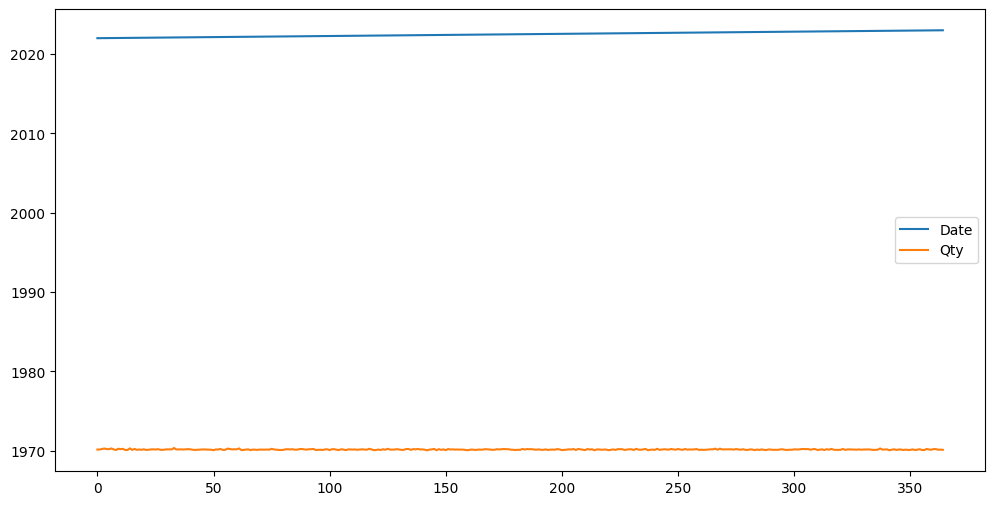

In [29]:
# Visualize Data
df_regresi.plot(figsize=(12,6))

## uji Stasioner


In [30]:
from statsmodels.tsa.stattools import adfuller
hasil = adfuller(df_regresi['Qty'])
print('ADF Statistic:  %f' % hasil[0])
print('p-value: %f' % hasil[1])
print('Critical Value:')
for key, value in hasil [4].items():
  print('t%s: %.3f' % (key, value))

ADF Statistic:  -19.018783
p-value: 0.000000
Critical Value:
t1%: -3.448
t5%: -2.870
t10%: -2.571


## P-Value < 0,05 menunjukkan bahwa data stasioner

# CHECK


In [31]:
cut_off =round(df_regresi.shape[0] * 0.8)
df_train =df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [32]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [ ]:
df_test

,Date,Qty
0,25/05/2022,56
1,25/06/2022,73
2,25/07/2022,73
3,25/08/2022,78
4,25/09/2022,38
...,...,...
68,31/05/2022,21
69,31/07/2022,72
70,31/08/2022,36
71,31/10/2022,69


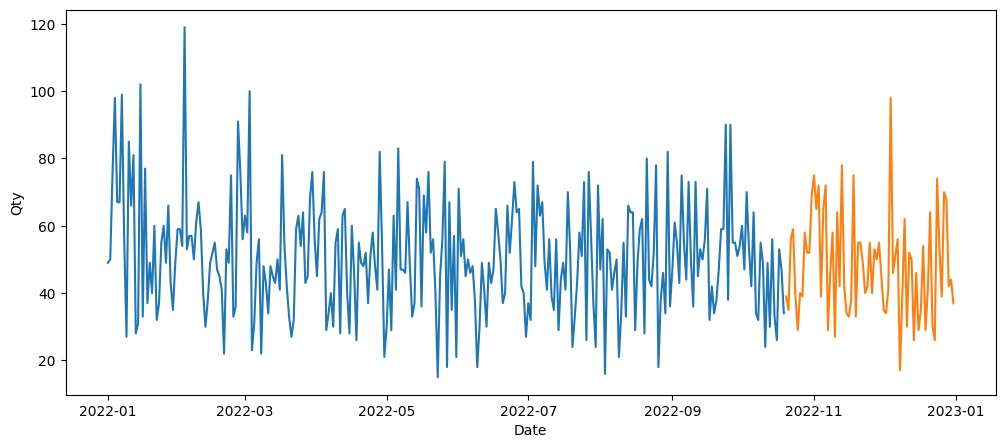

In [33]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty']);
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty']);


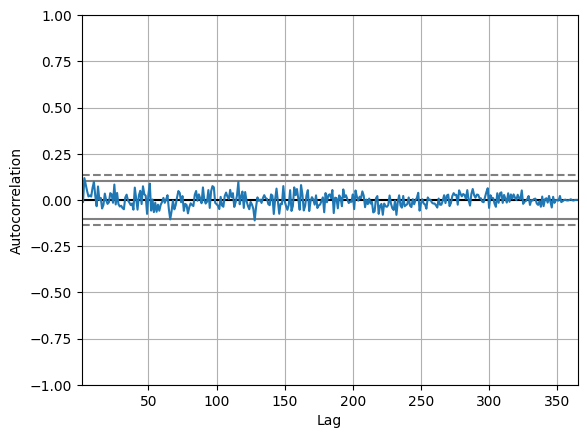

In [ ]:
autocorrelation_plot(df_regresi ['Qty']);

In [ ]:
def rmse(y_actual, y_perd):

  print(f'RMSE value{mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
  rmse(y_actual, y_pred)
  print(f'MAE value{mean_squared_error(y_actual, y_pred)}')

#CLUSTERING

In [ ]:
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500


In [42]:
df_cluster = df_merged.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_cluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [44]:
df_cluster = df_cluster.drop(columns = ['CustomerID'])

df_cluster.head()



,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


In [45]:
X = df_cluster.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_cluster.columns)
df_std.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [ ]:
#Normalisasi dataset dengan minmaxscaler
X_normalize = MinMaxScaler().fit_transform(X)
X_normalize

array([[0.77777778, 0.72463768, 0.70394911],
       [0.55555556, 0.68115942, 0.39782666],
       [0.66666667, 0.66666667, 0.46925523],
       ...,
       [0.83333333, 0.84057971, 0.6561092 ],
       [0.44444444, 0.46376812, 0.43890803],
       [0.55555556, 0.46376812, 0.46011132]])

In [46]:
K = range(2,8)
fits=[]
score=[]

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(X_std)
    fits.append(model)
    score.append(silhouette_score(X_std, model.labels_, metric='euclidean'))

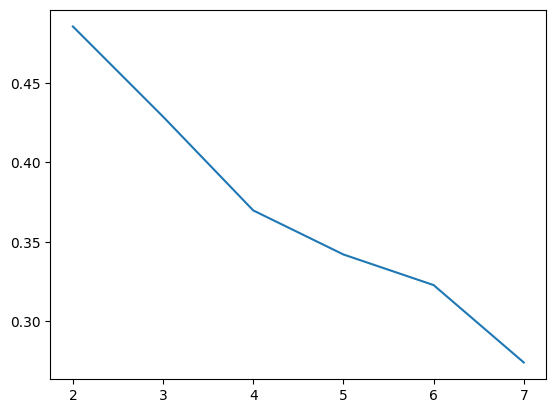

In [ ]:
sns.lineplot(x = K, y = score);

In [ ]:
fits[2]

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [47]:
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=100)
kmeans_4.fit(X_std)

KMeans(n_clusters=4, n_init=10, random_state=100)

In [48]:
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.head()

,TransactionID,Qty,TotalAmount,cluster
0,17,60,623300,3
1,13,57,392300,1
2,15,56,446200,1
3,10,46,302500,0
4,7,27,268600,2


<Figure size 600x600 with 0 Axes>

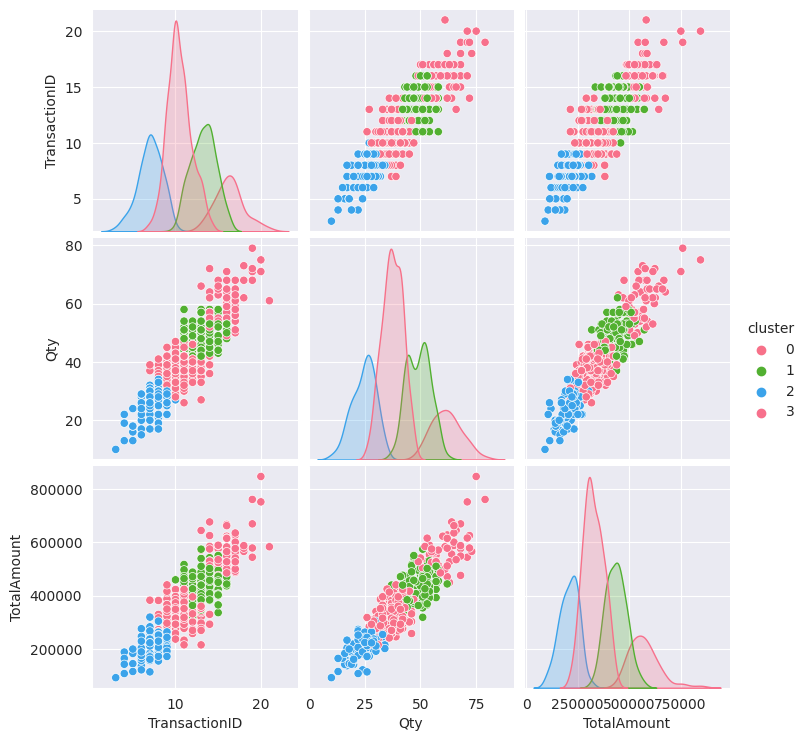

In [76]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster, hue='cluster', palette='husl')
plt.show()

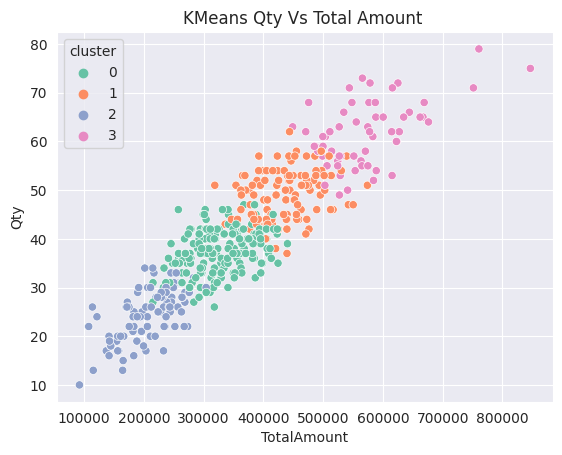

In [84]:
sns.scatterplot( y="Qty", x="TotalAmount", hue="cluster", data=df_cluster, palette="Set2")




# Customize plot

plt.title("KMeans Qty Vs Total Amount ")

plt.xlabel("TotalAmount")

plt.ylabel("Qty")

plt.show()

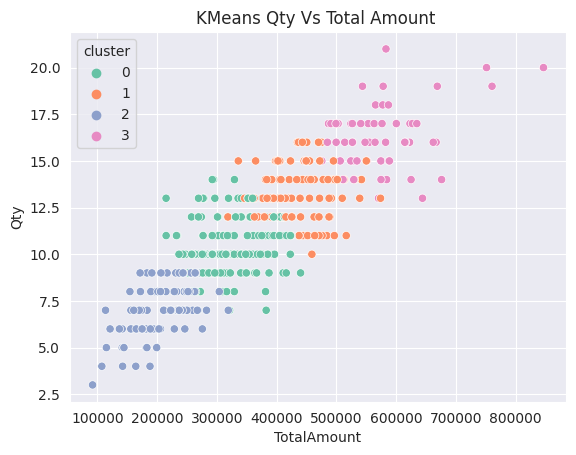

In [85]:
sns.scatterplot( y="TransactionID", x="TotalAmount", hue="cluster", data=df_cluster, palette="Set2")




# Customize plot

plt.title("KMeans Qty Vs Total Amount ")

plt.xlabel("TotalAmount")

plt.ylabel("Qty")

plt.show()